# TP3

## Practical work on audio source separation

Student : Thibault LAHIRE

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from scipy.io import wavfile
import mdct
from scipy.io.wavfile import write

In [2]:
def load_music(file):
    return wave.open(file, 'rb')


def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def write_file(data, Fs, name):
    scaled = np.int16(data/np.max(np.abs(data)) * 32767)
    write(name+'.wav', Fs, scaled)
    return name+'.wav'

def listen_file(filename):
    current_path = os.getcwd()
    data_path = os.path.join(current_path, 'Sons')
    music = os.path.join(data_path, filename)
    play_music(music)

In [3]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'Sons')
filename = 'mix.wav'
music = os.path.join(data_path, filename) 

In [4]:
wavefile = load_music(music)
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
play_music(music)

_wave_params(nchannels=2, sampwidth=2, framerate=22050, nframes=220501, comptype='NONE', compname='not compressed')


In [5]:
rate, X = wavfile.read('Sons/mix.wav')
print(X.shape)

(220501, 2)


Question 1. There are K = 3 instruments : a guitar, a piano, and a bass. The guitar comes from the left headphone, and the bass from the right. It is difficult to say where the piano comes from...

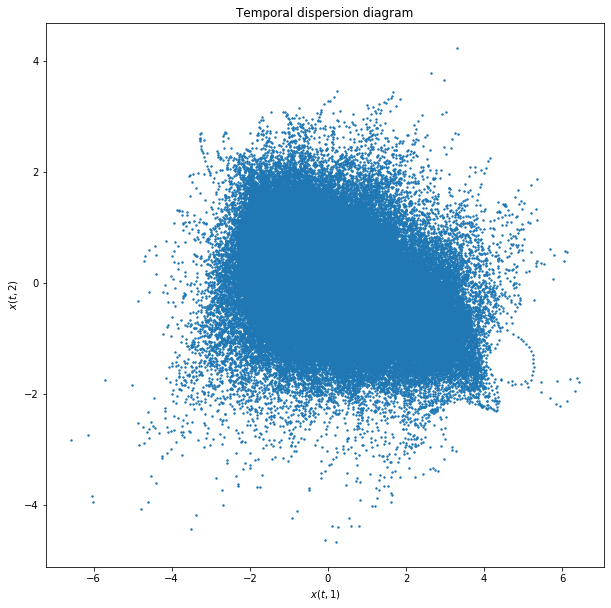

In [6]:
X_norm = (X-np.mean(X))/np.std(X)
plt.figure(figsize=(10, 10))
plt.scatter(X_norm[:,0], X_norm[:,1], s=2)
plt.title('Temporal dispersion diagram')
plt.xlabel('$x(t,1)$')
plt.ylabel('$x(t,2)$')
plt.show()

Question 2. As shown in the cell above, it is not possible to distinguish the directions of the sources. With such a simple method, it would have been possible if the instruments played separately in time, but it is not the case. That's why we will now use both time and frequency.

In [7]:
X_mdct = mdct.mdct(x=X, window=scipy.signal.hanning, framelength=512)
print(X_mdct.shape)

(256, 863, 2)


Question 3. As shown above, there are 256 frequency channels and 863 is the length of the MDCT. We plot below the time-frequency representations for each channel. Note that we used np.log for the display. 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


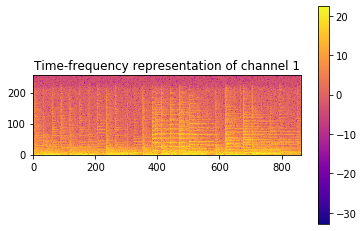

In [8]:
plt.imshow(np.log(X_mdct[:,:,0]**2),cmap="plasma")
plt.title('Time-frequency representation of channel 1')
plt.colorbar()
plt.gca().invert_yaxis()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


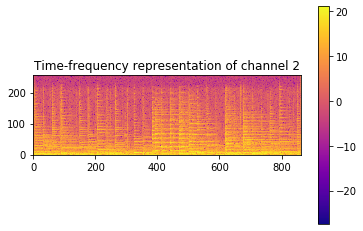

In [9]:
plt.imshow(np.log(X_mdct[:,:,1]**2),cmap="plasma")
plt.title('Time-frequency representation of channel 2')
plt.colorbar()
plt.gca().invert_yaxis()

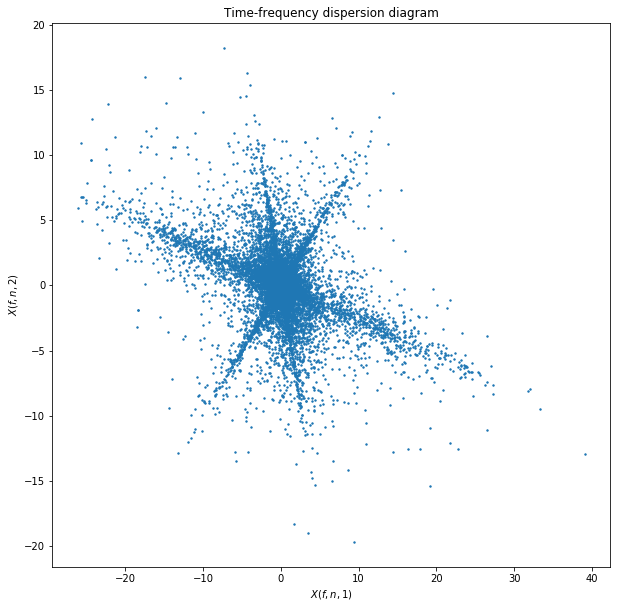

In [10]:
X_1_mdct = X_mdct[:,:,0].flatten()
X_2_mdct = X_mdct[:,:,1].flatten()
X_mdct_flat = np.vstack((X_1_mdct, X_2_mdct)).T
X_mdct_norm = (X_mdct_flat - np.mean(X_mdct_flat))/np.std(X_mdct_flat)
plt.figure(figsize=(10,10))
plt.scatter(X_mdct_norm[:,0], X_mdct_norm[:,1], s=2)
plt.title('Time-frequency dispersion diagram')
plt.xlabel('$X(f,n,1)$')
plt.ylabel('$X(f,n,2)$')
plt.show()

Question 4. Now it is easier to distinguish the 3 sources, because we have taken the frequency into account. Indeed, even if instruments play together, they don't play at the same frequency, so it becomes possible to separate them.

Text(0.5, 1.0, 'Histogram of the arguments of the points of affix $Z(f,n)$. x-axis is between $-\\pi / 2 ; \\pi / 2$')

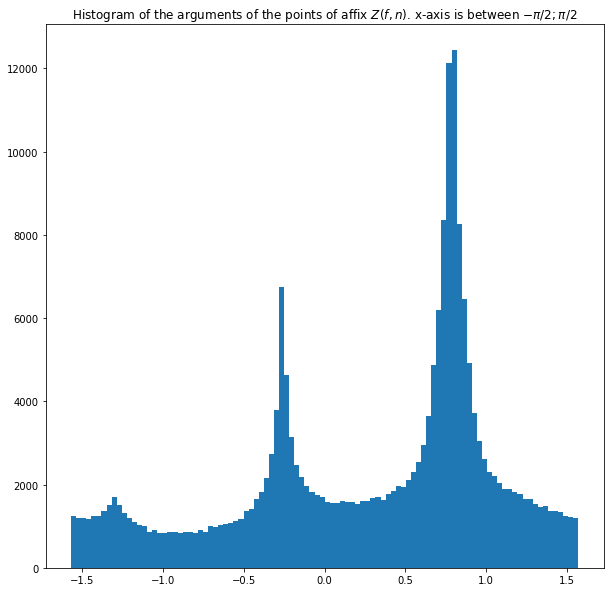

In [11]:
arguments = np.arctan(X_mdct_norm[:,0]/X_mdct_norm[:,1])
plt.figure(figsize=(10,10))
plt.hist(arguments, bins=100)
plt.title('Histogram of the arguments of the points of affix $Z(f,n)$. x-axis is between $-\pi / 2 ; \pi / 2$')

Question 5. Graphically, we have $\theta_1 = 0.84$ rad, $\theta_2 = -0.28$ rad and $\theta_3 = -1.32$ rad. We need to put these angles in $[0;\pi]$.

In [12]:
theta_1 = 0.84 + np.pi/2 # rad
theta_2 = -0.28 + np.pi/2 # rad
theta_3 = -1.32 + np.pi/2 # rad

X_1_mdct = mdct.mdct(x=X[:,0], window=scipy.signal.hanning, framelength=512)
X_2_mdct = mdct.mdct(x=X[:,1], window=scipy.signal.hanning, framelength=512)
arg = np.arctan(X_1_mdct/X_2_mdct)

dists_theta1 = np.abs(np.sin(theta_1-arg))
dists_theta2 = np.abs(np.sin(theta_2-arg))
dists_theta3 = np.abs(np.sin(theta_3-arg))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Question 6. We now generate the binary masks. 

In [13]:
B_1 = np.zeros(X_1_mdct.shape)
B_2 = np.zeros(X_1_mdct.shape)
B_3 = np.zeros(X_1_mdct.shape)

for i in range(B_1.shape[0]):
    for j in range(B_1.shape[1]):
        if dists_theta1[i,j] <= dists_theta2[i,j]:
            if dists_theta2[i,j] <= dists_theta3[i,j]:
                B_3[i,j] = 1
            else:
                B_2[i,j] = 1
        elif dists_theta1[i,j] <= dists_theta3[i,j]:
            if dists_theta3[i,j] <= dists_theta2[i,j]:
                B_2[i,j] = 1
            else:
                B_3[i,j] = 1
        else:
            B_1[i,j] = 1

Question 7. We apply the binary masks.

In [14]:
Y_1_1 = B_1*X_1_mdct
Y_1_2 = B_1*X_2_mdct
Y_2_1 = B_2*X_1_mdct
Y_2_2 = B_2*X_2_mdct
Y_3_1 = B_3*X_1_mdct
Y_3_2 = B_3*X_2_mdct

y_1_1 = mdct.imdct(Y_1_1, window=scipy.signal.hanning, framelength=512).astype('int')
y_1_2 = mdct.imdct(Y_1_2, window=scipy.signal.hanning, framelength=512).astype('int')
y_2_1 = mdct.imdct(Y_2_1, window=scipy.signal.hanning, framelength=512).astype('int')
y_2_2 = mdct.imdct(Y_2_2, window=scipy.signal.hanning, framelength=512).astype('int')
y_3_1 = mdct.imdct(Y_3_1, window=scipy.signal.hanning, framelength=512).astype('int')
y_3_2 = mdct.imdct(Y_3_2, window=scipy.signal.hanning, framelength=512).astype('int')

y1 = (y_1_1 + y_1_2)/2
y2 = (y_2_1 + y_2_2)/2
y3 = (y_3_1 + y_3_2)/2

/anaconda3/lib/python3.7/site-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/anaconda3/lib/python3.7/site-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


Question 8. We listen to the 3 reconstructed stereophonic images. We hear a noise like a sound of "water flowing".

In [15]:
write_file(y1, Fs, 'Sons/y1')
listen_file('y1.wav')

In [16]:
write_file(y2, Fs, 'Sons/y2')
listen_file('y2.wav')

In [17]:
write_file(y3, Fs, 'Sons/y3')
listen_file('y3.wav')

The piano is quite well separated from the rest on y1, the guitar on y2, and the bass on y3. In the middle of the sound excerpt of y2, the guitar disappears then reappears...

Question 9. We now compute the MMSE and reconstruct the source signals. 

In [18]:
S_1 = Y_1_1*np.cos(theta_1) + Y_1_2*np.sin(theta_1)
S_2 = Y_2_1*np.cos(theta_2) + Y_2_2*np.sin(theta_2)
S_3 = Y_3_1*np.cos(theta_3) + Y_3_2*np.sin(theta_3)

s1 = mdct.imdct(S_1, window=scipy.signal.hanning, framelength=512).astype('int')
s2 = mdct.imdct(S_2, window=scipy.signal.hanning, framelength=512).astype('int')
s3 = mdct.imdct(S_3, window=scipy.signal.hanning, framelength=512).astype('int')

In [19]:
s1 = 33*s1 # to have a better sound effect when recombining for question 10
write_file(s1, Fs, 'Sons/s1')
listen_file('s1.wav')

In [20]:
s2 = 2*s2 # to have a better sound effect when recombining for question 10
write_file(s2, Fs, 'Sons/s2')
listen_file('s2.wav')

In [21]:
write_file(s3, Fs, 'Sons/s3')
listen_file('s3.wav')

Question 10. We wish to respatialize the sources. We have the piano on s1, the guitar on s2, and the bass on s3. We put the guitar source on the right headphone, the bass on the right, and we delete the piano. It works, but sometimes we hear too much the "water flowing" since we did many approximation errors during the whole process (especially when we transformed float to integer...).

In [22]:
new_ch1 = s2
new_ch2 = s3
new_mix = np.vstack((new_ch1, new_ch2)).T.astype('int16')

In [23]:
wavfile.write('Sons/new_mix.wav', rate, new_mix)

In [24]:
listen_file('new_mix.wav')